# Recherche de modèles pour la prédiction de la consommation d'énergie et des émissions de gaz à effets de serre

## Sommaire

* [1 - Préparation du notebook](#chapter1)


* [2 - Prédiction de la consommation d'énergie](#chapter2)
    * [2.1. Création d'un modèle "baseline"](#section_2_1)
        * [2.1.1. Préparation des données](#section_2_1_1)
        * [2.1.2. Création d'un modèle de base](#section_2_1_2)
        * [2.1.3. Evaluation du modèle avec le jeu de test](#section_2_1_3)
    * [2.2. Choix du modèle le plus adapté](#section_2_2)
    * [2.3. Choix des hyperparamètres](#section_2_3)
    * [2.4. Analyses des erreurs](#section_2_4)
    * [2.5. Pipeline final](#section_2_5)
    
    
* [3 - Prédiction des émissions de gaz à effets de serre](#chapter3)
    * [3.1. Préparation des variables](#section_3_1)
    * [3.2. Création d'un modèle "baseline"](#section_3_2)
    * [3.3. Choix du modèle le plus adapté](#section_3_3)
    * [3.4. Choix des hyperparamètres](#section_3_4)
    * [3.5. Analyses des erreurs](#section_3_5)
    * [3.6. Pipeline finale](#section_3_6)
    
* [4 - Prédiction des émissions de gaz à effets de serre à l'aide de l'ENERGYSTAR Score](#chapter4)

* [5 - Conclusion](#chapter5)

* [Bonus : Prédiction à l'aide de réseau de neurones](#chapter6)

# 1) Préparation du notebook <a class="anchor" id="chapter1"></a>

In [1]:
# importation des librairies nécessaires aux tests de modèle
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot, prediction_error

In [2]:
# Paramétrage visuelle de Scikit-Learn
sklearn.set_config(display="diagram")

In [3]:
# Fonction permettant de calculer le RMSPE
# source : https://stackoverflow.com/questions/53165807/how-to-calculate-rmspe-in-python-using-numpy
def rmpse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true))))

    return loss

In [4]:
# Fonction d'évaluation des modèles de régression
def regression_metrics(y_test, y_pred):
    """Function which contains differents metrics about regression
    Input: y_test, prediction
    
    Output: MAE, MSE, RMSE, MAPE & R² score  
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmpse_cal = rmpse(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted")
    print("MAE: ",mae.round(5))
    print("MSE: ", mse.round(5))
    print("RMSE: ", rmse)
    print("RMPSE: ", rmpse_cal.round(3))
    print("MAPE: ", mape.round(5))
    print("R²: ", r_score.round(5))

In [5]:
# importation des données
data = pd.read_csv("datasets/benchmark_total.csv")
data.head(3)

,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Latitude,Longitude,NbofFloors,NbofBuildings,Age,Bins_Age,degreeDaysH,degreeDaysC,HasParking,Clusters
0,Hotel,Downtown,1927,1.0,12.0,88434,65.0,6981428.0,249.43,47.61220,-122.33799,2+f,1b,88,Very Old,4005,409,No,3
1,Hotel,Downtown,1927,1.0,12.0,88434,60.0,7226362.5,249.98,47.61220,-122.33799,2+f,1b,89,Very Old,4093,252,No,3
2,Hotel,Downtown,1996,1.0,11.0,103566,51.0,8354235.0,263.51,47.61317,-122.33393,2+f,1b,19,Recent,4005,409,Yes,3


Une fois que l'on a chargé les données, on va pouvoir séparer notre jeu de données en deux parties : un train set et un test set. On ne va pas toucher aux données du test set car il nous servia pour la validation de notre modèle. C'est grâce à ce jeu de données que l'on pourra sortir les metrics nécessaires. Dans chaque jeu (entraînement et test), on supprime les variables qui ne seront pas utiles dans notre modélisation. 

Tout d'abord, on supprime les variables que l'on cherche à prédire. "SiteEnergyUse(kBtu)" et "TotalGHGEmissions" sont les deux cibles que l'on cherche à prédire, on les mettra donc dans une variable y. Ensuite, notre jeu de données comporte de nombreuses valeurs : certaines sont d'origine et d'autres proviennent d'une opération de feature engineering. On va donc supprimer les doublons pour éviter la fuite de donneés. 
- Le score ENERGYSTAR est enlevé car on ne va pas s'en servir pour prédire la consommation d'énergie. On regardera son impact dans la prédiction des effets de gaz à effets de serre dans un second temps. 
- L'âge et l'année de construction des bâtiments sont supprimées. On va leur préférence l'utilisation d'une variable catégorielle en 4 modalités pour avoir cette information. La construction de cette variable est expliquée dans la partie "Analyse".
- Le nombre de bâtiments est supprimé et est remplacé par une variable catégorielle qui indique s'il y a 0, 1 ou 2 et plus de bâtiments sur la propriété. Ainsi la compréhension du modèle sera simpligiée par la suite.
- Pour le nombre d'étages, la logique est identique à celle du nombre de bâtiments. Ces simplifications permettent aussi de palier à la "mauvaise" distribution de nos variables. 
- Le quartier est supprimé ainsi que la longitude et la latitude. Ces informations concernent la localisation de la propriété. L'information de la localisation se trouve dans la variable "Cluster". Les explications de la création de cette variable se trouvent dans le notebook d'analyse. 

In [6]:
# Transformation logarithmique des variables cibles
# L'analyse exploratoire a montré qu'elles ne suivaient pas une loi normale
data["SiteEnergyUse(kBtu)_log"] = np.log(data["SiteEnergyUse(kBtu)"])
data["TotalGHGEmissions_log"] = np.log(data["TotalGHGEmissions"])

In [7]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
# Stratification sur la variable "type de propriété" (80% de bureau dans notre échantillon)
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["PrimaryPropertyType"])

y_train = train_set[["SiteEnergyUse(kBtu)_log"]]
y_test = test_set[["SiteEnergyUse(kBtu)_log"]]
X_train = train_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "ENERGYSTARScore", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors", "Neighborhood", "Latitude", "Longitude"], axis=1)
X_test = test_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "ENERGYSTARScore", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors","Neighborhood", "Latitude", "Longitude"], axis=1)

# 2) Prédiction de la consommation d'énergie <a class="anchor" id="chapter2"></a>

## 2.1) Création d'un modèle "baseline" <a class="anchor" id="section_2_1"></a>

### 2.1.1) Préparation des données <a class="anchor" id="section_2_1_1"></a>

On sépare les variables catégorielles des variables numériques. Pour pouvoir leur appliquer des traitements différents qui seront enregistrés dans un pipeline de préprocessing. 
Pour les variables catégorielles : 
- On complète les valeurs manquantes par le mode (celle qui est le plus fréquent)
- On les transforme via un OneHotEncoding. Ainsi, elles seront transformées en valeur numérique compréhensible par notre modèles.

Pour les variables numériques : 
- On complète les valeurs manquantes par la médiane. Il y a une grande diversité dans nos valeurs numériques sans que cela soit des anomalies. Néanmoins, elles vont faire varier notre moyenne, c'est pourquoi on choisi ici la médiane.
- On standardise nos variables pour enlever les unités qui sont différents (degré Fahrenheit pour Degree Days Heating & Cooling ; sq/ft² pour la taille de la propriété).

In [8]:
# Séparation des variables catégorielles et numériques
cat_var = ["PrimaryPropertyType", "NbofFloors", "NbofBuildings", "HasParking", "Clusters", "Bins_Age"]
num_var = ["PropertyGFATotal", "degreeDaysH", "degreeDaysC"]

In [9]:
# Création d'un pipeline de transformation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [10]:
# transformation des variables
X_train = preprocessor.fit_transform(X_train)

### 2.1.2) Création du modèle de base <a class="anchor" id="section_2_1_2"></a>

Le modèle choisi pour obtenir une baseline est un modèle naïf. Ce type de modèle prédit la valeur médiane de la variable cible. Le but étant d'avoir une prédiction proche de ce que ferait un modèle basé sur le hasard. Les métriques qui sortiront de ce modèle serviront de base pour évaluer les performances d'autres modèles. 

In [11]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

### 2.1.3) Evaluation du modèle avec le jeu de test <a class="anchor" id="section_2_1_3"></a>

In [12]:
# Prédiction à l'aide de notre dummy regressor
# Evaluation du modèle
X_test = preprocessor.transform(X_test)
y_pred = dummy_reg.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  0.98081
MSE:  1.5836
RMSE:  1.258410344163992
RMPSE:  0.084
MAPE:  0.0661
R²:  -4e-05


Les mesures pour évaluer notre méthode sont le MAE, le MSE (qui s'exprime en log²), le RMSE (qui s'exprime en log), le RMSE, le RMPSE (% de RMSE pour mieux comparer), le MAPE et le coefficient de détermination R². 

## 2.2) Choix du modèle le plus performant <a class="anchor" id="section_2_2"></a>

Le problème à laquelle nous sommes confrontés est un problème de régression. On va donc choisir des modèles qui peuvent permettre de faire ce type de prédiction. On va choisir des méthodes linéaires : Régression linéaire et ses variantes régularisées (Ridge et Lasso), le Support Vecteur Machine et des méthodes non linéaires : la régression linéaire ridge avec noyau, des méthodes ensemblistes de bagging (Bagging, Random Forest) et de boosting (AdaBoost, Gradient Boosting, XGBoost).

In [13]:
# instanciation des différents modèles de régression
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=42)
bagging = BaggingRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
xgboost = xgb.XGBRegressor(random_state=42)
mlp_reg = MLPRegressor(random_state=42)

In [14]:
# Entraînement des modèles sans paramètre spécifique
# Sortie de 4 mesures : MAE, MSE, RMSE, R²
model = [dummy_reg, lin_reg, ridge, lasso, dt_reg, svm_reg, ridge_kernel, adaboost, bagging, gdboost, rdmforest, xgboost, mlp_reg]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "Ridge", "Lasso", "DecisionTree", "SVM", "Ridge Kernel",
                      "AdaBoost", "Bagging", "GradientBoosting", "Random Forest", "XGBoost", "MLP"]

eval_model

,Dummy Regressor,Linear Regression,Ridge,Lasso,DecisionTree,SVM,Ridge Kernel,AdaBoost,Bagging,GradientBoosting,Random Forest,XGBoost,MLP
MAE,0.981,0.710,0.708,1.008,0.332,0.549,0.709,0.580,0.373,0.459,0.356,0.350,0.525
MSE,1.584,0.817,0.817,1.605,0.356,0.530,0.817,0.599,0.280,0.396,0.252,0.233,0.490
RMSE,1.258,0.904,0.904,1.267,0.597,0.728,0.904,0.774,0.529,0.629,0.502,0.483,0.700
R²,-0.000,0.484,0.484,-0.013,0.775,0.665,0.484,0.622,0.823,0.750,0.841,0.853,0.691


La régression naïve apparaît bien comme l'un des modèles les moins performants. On remarque que les modèles linéaires (Régression linéaire, Régression Ridge/Lasso et SVM) ont un coefficient de détermination aux alentours de 50%. Cela montre que notre problème n'est pas un problème linéaire. On va donc devoir se tourner vers des méthodes non-linéaires. Le modèle de Random Forest ainsi que l'algorithme de XGBoost sont ceux qui obtiennent les meilleures performances. On va donc s'orienter sur l'algorithme XGBoost. Ces hyperparamètres seront affinés pour obtenir la meilleure performance pour notre modèle. 


**Choix du modèle :** XGBoost

## 2.3) Choix des hyperparamètres <a class="anchor" id="section_2_3"></a>

On va commencer par définir quelques paramètres de notre algorithme de XGBoost. On va choisir de booster un modèle se basant sur des arbres de décision (gbtree), on va ensuite fixer sa racine aléatoire et on va ensuite choisir un nombre d'arbres dans notre algorithme. On sait que le nombre d'arbres améliore la performance de notre modèle. Plus il y a d'arbres, plus le modèle sera bon. Ce paramètre n'est pas un hyperparamètre et doit être ajusté en fonction des limitations matérielles. Ici, le nombre d'arbres fera fixé à 400.

In [15]:
# instanciation du modèle avec paramètre de base : type de boost, racine aléatoire et nombre d'arbres à booster
xgboost_energy = xgb.XGBRegressor(objective="reg:squarederror", booster="gbtree", 
                               random_state=42, n_estimators=400, tree_method="hist", n_jobs=-1)

Une fois le modèle choisi, on va pouvoir s'occuper de ces hyperparamètres. On va s'interesser à la profondeur des arbres, à son coût d'apprentissage, à son paramètre gamma et à la méthode utilisée pour le boostraping. 

La profondeur des arbres (**max_depth**) va correspondre au nombre "d'étages" de chacun de nos arbres. L'augmentation de ce paramètre va rendre notre modèle plus complexe et plus à même de faire du sur-apprentissage (ou *overfitting*). Le coût d'apprentissage (**learning_rate** ou $\eta$) va venir contrebalancer les effets de sur-apprentissage (*overfitting*). L'hyperparamètre **gamma** ($\gamma$) permet de minimiser la perte observée lors de chaque séparation des branches de l'arbre. Plus il sera grand, plus l'algorithme conservera sa perte. Le poids minimum des enfants (**min_child_weight**) détermine le nombre d'individus minimum pour que notre noeud puisse être constitué. Enfin, la méthode de bootstraping (**sampling_method**) désigne la méthode selon laquelle les différents échantillons sont crées pour entraîner chacun de nos arbres. Ici, on peut choisir entre une méthode uniforme où chaque élément a la même probabilité d'être tiré au sort ou une méthode se basant sur un gradient. 

In [16]:
# Grille de recherche de la meilleure configuration d'hyperparamètres
# Ajout d'une validation croisée pour diminuer les risques d'overfitting
from sklearn.model_selection import GridSearchCV

params = [{"max_depth" : [7, 8, 9, 10, 11, 12],
           "learning_rate" : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
           "gamma" : [3, 4, 5],
           "min_child_weight" : [2, 3, 4, 5], 
           "sampling_method" : ["uniform", "gradient_based"]
}]

grid_search = GridSearchCV(xgboost_energy, params, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=400, n_j...
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method='hist',
                                    validate_parameters=None, verbosity=None),
             param_grid=[{'gamma': [3, 4, 5],
                          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25,
                                            0.3],
                          'max_depth': [7, 8, 9, 10, 11, 12],
                          'min_child_weight': [2, 3, 4, 5],
                          'sampling_method': ['uniform', 'gradient_based']}],
             scoring='neg_mean_squared_error')

In [17]:
# Visualisation des meilleurs paramètres
grid_search.best_params_

{'gamma': 3,
 'learning_rate': 0.2,
 'max_depth': 12,
 'min_child_weight': 2,
 'sampling_method': 'uniform'}

In [18]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=12,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, sampling_method='uniform',
             scale_pos_weight=1, subsample=1, tree_method='hist',
             validate_parameters=1, verbosity=None)

Notre modèle est enregistré dans la grille de recherche. On va ensuite l'affecter à une variable pour tester ces performances sur un jeu de test. 

## 2.4) Analyse des erreurs du modèle <a class="anchor" id="section_2_4"></a>

Une fois le modèle sélectionné et les hyperparamètres choisis, on va pouvoir évaluer les performances du modèle sur un jeu qu'il n'a pas encore vu : le jeu de test. 

In [19]:
# Attribution du modèle entraîné à une variable
final_model_energy = grid_search.best_estimator_

In [20]:
final_predictions_energy = final_model_energy.predict(X_test)

In [21]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.45626
MSE:  0.3768
RMSE:  0.6138374528191006
RMPSE:  0.109
MAPE:  0.03131
R²:  0.76205


L'évaluation finale de notre modèle montre des scores plutôt bons. Notre modèle estime la consommation d'énergie avec une erreur de plus ou moins 0.11% (RMPSE : 0.109%). Il a un coefficient de détermination de 76%, c'est-à-dire qu'il permet d'expliquer 76% de la variance observée dans nos variables cibles. De plus, l'erreur moyenne est de 0.03% (MAPE). 

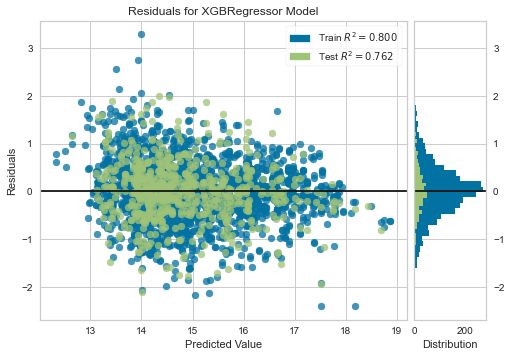

In [22]:
visualizer = ResidualsPlot(final_model_energy)
visualizer.fit(np.array(X_train), np.array(y_train).reshape(2596,))
visualizer.score(np.array(X_test), np.array(y_test).reshape(649,))
visualizer.show();

Les distributions des résidus du jeu d'entraînement et du jeu de test semblent suivre une loi normale. La distribution des résidus du jeu de test est plus aplatie. Cela peut s'expliquer par le nombre de données moins importants (seulement 20% de l'échantillon). 

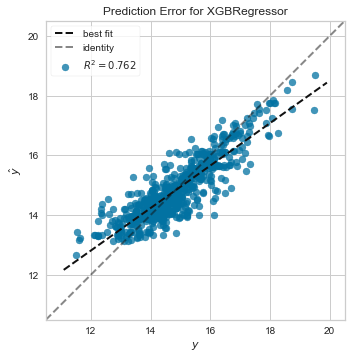

In [23]:
visualizer = prediction_error(final_model_energy, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));

L'analyse des erreurs de prédiction ne montre pas d'anomalie particulière dans notre modèle. On peut donc l'enregistrer dans un pipeline pour pouvoir le déployer le moment venu. 

## 2.5) Pipeline du modèle pour l'estimation de la consommation d'énergie <a class="anchor" id="section_2_5"></a>

In [24]:
# création de pipeline contenant la transformation des variables et le modèle entraîné
# elle peut être utilisée pour faire des prédictions sur de nouvelles variables

full_pipeline_energy = Pipeline([
    ("preprocessing", preprocessor),
    ("model", final_model_energy)
])

Le modèle choisi est prêt à être déployé pour pouvoir prédire la consommation d'énergie. Il pourra être intéressant de le réentraîner en ne faisant aucune modification logarithmique de notre cible. En effet, les modèles se basant sur des arbres de décisions ne sont pas impactés par le non-respect de la loi normale. 

# 3) Prédiction des émissions de CO2 <a class="anchor" id="chapter3"></a>

Pour la prédiction des émissions de CO$_2$, la méthode est la même que pour la prédiction de la consommation d'énergie. Cette fois-ci, la méthodologie ne sera pas aussi détaillé que pour la consommation d'énergie. 

La prédiction des émissions de CO$_2$ se fera de deux manières : sans introduire le score ENERGYSTAR et en introduisant le score ENERGYSTAR.

## 3.1) Préparation des variables <a class="anchor" id="section_3_1"></a>

In [25]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["PrimaryPropertyType"])

y_train = train_set[["TotalGHGEmissions_log"]]
y_test = test_set[["TotalGHGEmissions_log"]]
X_train = train_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "ENERGYSTARScore", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors", "Neighborhood", "Latitude", "Longitude"], axis=1)
X_test = test_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "ENERGYSTARScore", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors","Neighborhood", "Latitude", "Longitude"], axis=1)

La transformation des variables étant identiques à la méthode ci-dessus, on n'utilise le même pipeline. Cependant, ici il y aura un entraînement sur le nouveau jeu de données X_train pour que les imputations et autres transformations correspondent aux statistiques descriptions de cet échantillon. 

In [26]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## 3.2) Création d'un modèle de base <a class="anchor" id="section_3_2"></a>

In [27]:
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [28]:
y_pred = dummy_reg.predict(X_test)

In [29]:
regression_metrics(np.array(y_test), y_pred)

MAE:  1.1754
MSE:  2.26512
RMSE:  1.5050313263804256
RMPSE:  1.629
MAPE:  0.56556
R²:  -0.00404


## 3.3) Choix du modèle <a class="anchor" id="section_3_3"></a>

In [30]:
dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=42)
bagging = BaggingRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
xgboost = xgb.XGBRegressor(random_state=42)
mlp = MLPRegressor(random_state=42)

In [31]:
model = [dummy_reg, lin_reg, ridge, lasso, dt_reg, svm_reg, ridge_kernel, adaboost, bagging, gdboost, rdmforest, xgboost, mlp]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "Ridge", "Lasso", "DecisionTree", "SVM", "Ridge Kernel",
                      "AdaBoost", "Bagging", "GradientBoosting", "Random Forest", "XGBoost", "MLP"]

eval_model

,Dummy Regressor,Linear Regression,Ridge,Lasso,DecisionTree,SVM,Ridge Kernel,AdaBoost,Bagging,GradientBoosting,Random Forest,XGBoost,MLP
MAE,1.175,0.932,0.931,1.180,0.548,0.805,0.931,0.903,0.601,0.761,0.572,0.577,0.775
MSE,2.265,1.430,1.428,2.276,0.887,1.156,1.428,1.272,0.680,0.948,0.623,0.621,1.061
RMSE,1.505,1.196,1.195,1.509,0.942,1.075,1.195,1.128,0.825,0.974,0.789,0.788,1.030
R²,-0.004,0.366,0.367,-0.009,0.607,0.488,0.367,0.436,0.698,0.580,0.724,0.725,0.530


Les modèles linéaires sont ceux avec les performances les moins bonnes ce qui montrent que le problème à laquelle nous sommes confrontés n'est pas linéaire. Les modèles ensemblistes sont ceux avec les meilleurs résultats. Ici, le choix a été fait d'améliorer les performances d'un XGBoost mais l'utilisation d'un Random Forest pourrait constituer une bonne alternative.

**Modèle choisi :** XGBoost

## 3.4) Choix des hyperparamètres <a class="anchor" id="section_3_4"></a>

In [32]:
xgboost_co2 = xgb.XGBRegressor(objective="reg:squarederror", booster="gbtree", 
                               random_state=42, n_estimators=400, tree_method="hist", n_jobs=-1)

In [33]:
params = [{"max_depth" : [7, 8, 9, 10, 11, 12],
           "learning_rate" : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
           "gamma" : [3, 4, 5, 6],
           "min_child_weight" : [2, 3, 4, 5, 6],
           "sampling_method" : ["uniform", "gradient_based"]
}]

grid_search = GridSearchCV(xgboost_co2, params, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=400, n_j...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method='hist',
                                    validate_parameters=None, verbosity=None),
             param_grid=[{'gamma': [3, 4, 5, 6],
                          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25,
                                            0.3],
                          'max_depth': [7, 8, 9, 10, 11, 12],
                          'min_child_weight': [2, 3, 4, 5, 6],
                          'sampling_method': ['uniform', 'gradient_based']}],
             scoring='neg_mean_squared_error')

In [34]:
grid_search.best_params_

{'gamma': 3,
 'learning_rate': 0.3,
 'max_depth': 12,
 'min_child_weight': 4,
 'sampling_method': 'uniform'}

## 3.5) Analyse des erreurs du modèle <a class="anchor" id="section_3_5"></a>

In [35]:
final_model_co2 = grid_search.best_estimator_

In [36]:
final_predictions_co2 = final_model_co2.predict(X_test)

In [37]:
regression_metrics(np.array(y_test), final_predictions_co2)

MAE:  0.68289
MSE:  0.79088
RMSE:  0.8893127232473764
RMPSE:  1.699
MAPE:  0.31652
R²:  0.64943


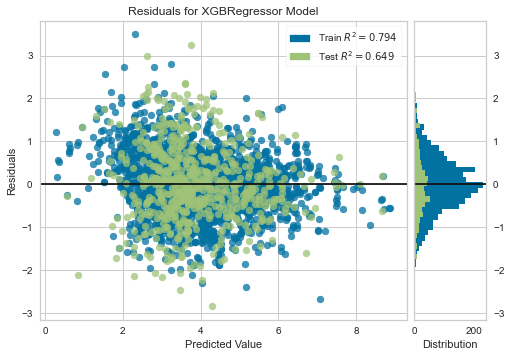

In [38]:
visualizer = ResidualsPlot(final_model_co2)
visualizer.fit(np.array(X_train), np.array(y_train).reshape(2596,))
visualizer.score(np.array(X_test), np.array(y_test).reshape(649,))
visualizer.show();

La différence entre le coefficient de détermination du jeu d'entraînement et du jeu de test montre qu'il y a overfitting de notre modèle malgré les précautions prises (validation croisée, contrainte du modèle en utilisant l'hypermètre $\eta$). Les scores observées sont moins bons que pour la prédiction de la consommation d'énergie. En effet, notre modèle n'explique que 65% de la variance observée. De plus, son pourcentage d'erreur moyenne (MAPE) est de 0.31%. Si on se réfère au pourcentage de RMSE (RMSPE), notre modèle donne une prédiction avec une erreur de plus ou moins 1.7%.

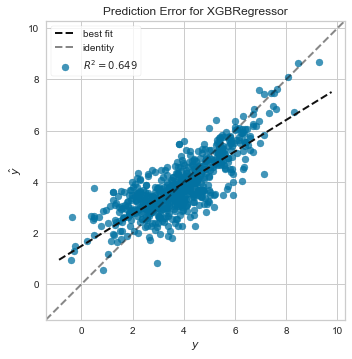

In [39]:
visualizer = prediction_error(final_model_co2, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));

La prédiction des émissions de CO$_2$ semble plus complexe que celle de la consommation d'énergie. Cela peut s'expliquer par le fait que nous ne disposons pas d'informations suffisantes pour faire cette prédiction. Contrairement à la consommation d'énergie, il est possible que d'autres variables interviennent dans notre modèle ce qui expliquerait, par exemple, que notre coefficient de détermination soit aussi faible. 

## 3.6) Pipeline du modèle pour l'estimation des émissions de CO2 <a class="anchor" id="section_3_6"></a>

In [40]:
full_pipeline_co2 = Pipeline([
    ("preprocessing", preprocessor),
    ("model", final_model_co2)
])

On enregistre tout de même ce modèle dans un pipeline. Malgré ses erreurs, il est utilisable pour obtenir une estimation des émissions de CO$_2$ mais il sera moins précis que l'estimation de la consommation d'énergie. 

# 4 - Prédiction des émissions de CO2 avec ENERGY STAR SCORE

Cette fois-ci, on va regarder si l'ajout du score ENERGY STAR va permettre d'améliorer notre modèle. 

## 4.1) Préparation des variables <a class="anchor" id="section_4_1"></a>

In [41]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["PrimaryPropertyType"])

y_train = train_set[["TotalGHGEmissions_log"]]
y_test = test_set[["TotalGHGEmissions_log"]]
X_train = train_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors", "Neighborhood", "Latitude", "Longitude"], axis=1)
X_test = test_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors","Neighborhood", "Latitude", "Longitude"], axis=1)

In [42]:
# Séparation des variables catégorielles et numériques

cat_var = ["PrimaryPropertyType", "NbofFloors", "NbofBuildings", "HasParking", "Clusters", "Bins_Age"]
num_var = ["PropertyGFATotal", "degreeDaysH", "degreeDaysC", "ENERGYSTARScore"]

In [43]:
# Création d'un pipeline de transformation

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [44]:
X_train = preprocessor.fit_transform(X_train)

## 4.2) Création d'un modèle de base <a class="anchor" id="section_4_2"></a>

In [45]:
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [46]:
X_test = preprocessor.transform(X_test)
y_pred = dummy_reg.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  1.1754
MSE:  2.26512
RMSE:  1.5050313263804256
RMPSE:  1.629
MAPE:  0.56556
R²:  -0.00404


## 4.3) Choix du modèle <a class="anchor" id="section_4_3"></a>

In [47]:
dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=42)
bagging = BaggingRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
xgboost = xgb.XGBRegressor(random_state=42)
mlp_reg = MLPRegressor(random_state=42)

In [48]:
model = [dummy_reg, lin_reg, ridge, lasso, dt_reg, svm_reg, ridge_kernel, adaboost, bagging, gdboost, rdmforest, xgboost, mlp]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "Ridge", "Lasso", "DecisionTree", "SVM", "Ridge Kernel",
                      "AdaBoost", "Bagging", "GradientBoosting", "Random Forest", "XGBoost", "MLP"]

eval_model

,Dummy Regressor,Linear Regression,Ridge,Lasso,DecisionTree,SVM,Ridge Kernel,AdaBoost,Bagging,GradientBoosting,Random Forest,XGBoost,MLP
MAE,1.175,0.913,0.910,1.180,0.580,0.781,0.910,0.908,0.613,0.727,0.575,0.560,0.757
MSE,2.265,1.377,1.363,2.276,0.938,1.056,1.363,1.264,0.663,0.848,0.581,0.575,0.964
RMSE,1.505,1.174,1.167,1.509,0.969,1.028,1.167,1.124,0.814,0.921,0.762,0.758,0.982
R²,-0.004,0.389,0.396,-0.009,0.584,0.532,0.396,0.440,0.706,0.624,0.743,0.745,0.573


La variable cible étant la même et les variables explications presque identiques, on se retrouve avec des résultats qui sont proches de ce qui avait été vu auparavant. Les modèles linéaires ne sont pas adaptées à notre problème de régression. Le choix se portera sur des modèles ensemblistes et plus particulièrement, l'algorithme de XGBoost. 

**Modèle choisi** : XGBoost

## 4.4) Recherche des hyperparamètres <a class="anchor" id="section_4_4"></a>

In [49]:
xgboost_ghg_energystar = xgb.XGBRegressor(objective="reg:squarederror", booster="gbtree", 
                               random_state=42, n_estimators=400, tree_method="hist", n_jobs=-1)

In [50]:
params = [{"max_depth" : [7, 8, 9, 10, 11, 12],
           "learning_rate" : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
           "gamma" : [3, 4, 5, 6],
           "min_child_weight" : [2, 3, 4, 5, 6],
           "sampling_method" : ["uniform", "gradient_based"]
}]

grid_search = GridSearchCV(xgboost_co2, params, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=400, n_j...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method='hist',
                                    validate_parameters=None, verbosity=None),
             param_grid=[{'gamma': [3, 4, 5, 6],
                          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25,
                                            0.3],
                          'max_depth': [7, 8, 9, 10, 11, 12],
                          'min_child_weight': [2, 3, 4, 5, 6],
                          'sampling_method': ['uniform', 'gradient_based']}],
             scoring='neg_mean_squared_error')

In [51]:
grid_search.best_params_

{'gamma': 3,
 'learning_rate': 0.2,
 'max_depth': 12,
 'min_child_weight': 3,
 'sampling_method': 'uniform'}

In [52]:
final_model_ghg = grid_search.best_estimator_

In [53]:
final_prediction_ghg = final_model_ghg.predict(X_test)

In [54]:
regression_metrics(np.array(y_test), final_prediction_ghg)

MAE:  0.66337
MSE:  0.72601
RMSE:  0.852059610977801
RMPSE:  1.69
MAPE:  0.30399
R²:  0.67819


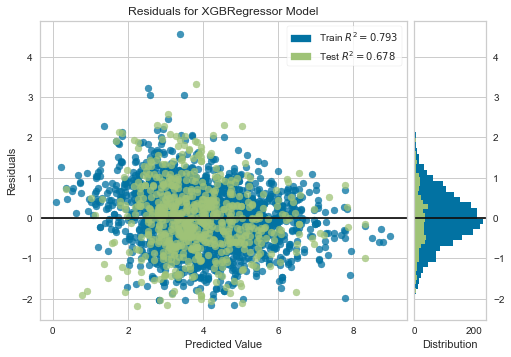

In [55]:
visualizer = ResidualsPlot(final_model_ghg)
visualizer.fit(np.array(X_train), np.array(y_train).reshape(2596,))
visualizer.score(np.array(X_test), np.array(y_test).reshape(649,))
visualizer.show();

Comme pour la prédiction sans utiliser le score ENERGY STAR, on observe un effet important de surapprentissage. Notre coefficient de détermination est légèrement plus élevée montrant que notre modèle capture presque 68% de la variance du phénomène. Ensuite, les mesures des erreurs montrent que notre modèle effectue des prédictions avec 0.30% d'erreur (MAPE) contre 0.31% sans le score ENERGY STAR. 

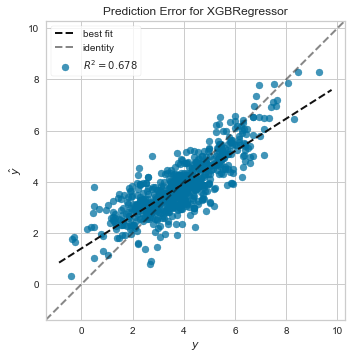

In [56]:
visualizer = prediction_error(final_model_ghg, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));

L'ajout d'une variable supplémentaire permet de construire un modèle qui capture un peu plus de variance mais sans diminuer de manière importante les erreurs commises par notre modèle. De plus, il y a un grand nombre de valeurs manquantes pour le score ENERGY STAR et ces valeurs manquantes ont été remplacés par la médiane ce qui peut introduire un biais dans notre modèle.

L'intérêt du score ENERGY STAR ne semble pas important dans notre modèle si on se réfère aux performances de ce dernier. 

## 4.5) Pipeline du modèle <a class="anchor" id="section_4_5"></a>

In [57]:
full_pipeline_ghg = Pipeline([
    ("preprocessing", preprocessor),
    ("model", final_model_ghg)
])

# 5 - Conclusion <a class="anchor" id="chapter5"></a>

Les informations dont l'on dispose nous permette d'avoir une estimation correcte de la consommation d'énergie. On dispose d'un modèle qui capture les 3/4 de la variance de notre phénomène. Les erreurs de prédictions sont plutôt faibles (0.11% si on prend le RMSPE ou 0.03% avec le MAPE). 

Concernant la prédiction de CO2, il semblerait que nos informations ne soient pas suffisantes pour obtenir un coefficient de détermination dépassant les 70%. Il faudrait donc obtenir des informations supplémentaires pour pouvoir obtenir une meilleure prédiction. L'ajout du score ENERGY STAR permet d'améliorer la variance expliquée par notre modèle sans pour autant réduire significativement les erreurs de prédiction. 

# Bonus : Prédiction à l'aide de méthode de Deep Learning <a class="anchor" id="chapter6"></a>

Cette partie n'était pas demandée mais des essais sur des réseaux de neurones ont été effectués pour voir s'il était possible d'améliorer les modèles présentés ci-dessus. 

## Prédiction de la consommation d'énergie

### Préparation des données

In [58]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["PrimaryPropertyType"])

y_train = train_set[["SiteEnergyUse(kBtu)_log"]]
y_test = test_set[["SiteEnergyUse(kBtu)_log"]]
X_train = train_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "ENERGYSTARScore", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors", "Neighborhood", "Latitude", "Longitude"], axis=1)
X_test = test_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "ENERGYSTARScore", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors","Neighborhood", "Latitude", "Longitude"], axis=1)

In [59]:
# Séparation des variables catégorielles et numériques

cat_var = ["PrimaryPropertyType", "NbofFloors", "NbofBuildings", "HasParking", "Clusters", "Bins_Age"]
num_var = ["PropertyGFATotal", "degreeDaysH", "degreeDaysC"]

In [60]:
# Création d'un pipeline de transformation
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [61]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### Création du modèle

On va créer notre modèle en lui ajoutant deux couches cachées avec une fonction d'activation Rectified Linear Unit (ou **relu**). La mesure d'évaluation choisie ici sera le MAE. On choisit de ne mettre que deux couches cachées car notre jeu de données est petit et ainsi on va limiter l'overfitting de notre réseau de neurones. Le code utilisé pour la création du modèle, la mise en place de validation croisée et le choix du nombre d'epochs s'est inspiré du livre *Deep Learning with Python* de François Chollet.

In [62]:
from tensorflow import keras

def build_model():
    model=keras.Sequential([
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])
    return model

- Mise en place d'une validation croisée avec K = 5

In [63]:
k = 5
num_val_samples = len(X_train)//k
num_epochs = 100
all_scores = []

for i in range(k):
    print(f"Processing fold #{i}")
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
    [X_train[:i * num_val_samples],
     X_train[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [y_train[:i * num_val_samples],
     y_train[(i + 1) * num_val_samples:]],
    axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [64]:
print(all_scores)
print("MAE moyen:", np.mean(all_scores).round(2))

[0.6336305141448975, 0.557069718837738, 0.8650035262107849, 0.5919190645217896, 0.5404641032218933]
MAE moyen: 0.64


Le MAE moyen à l'issue de notre validation croisée est de 0.64. On va reproduire cette validation croisée en augmentant le nombre d'epochs afin de choisir le nombre optimal pour notre réseau. 

In [65]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
    [X_train[:i * num_val_samples],
     X_train[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [y_train[:i * num_val_samples],
     y_train[(i + 1) * num_val_samples:]],
    axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [66]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

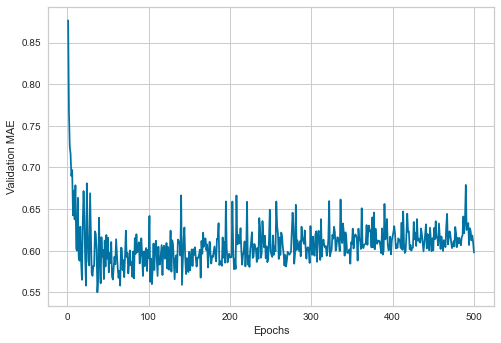

In [67]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

Les premiers epochs montrent des scores très importants. On va donc les supprimer pour pouvoir regarder de plus près le moment où l'augmentation du MAE stagne. 

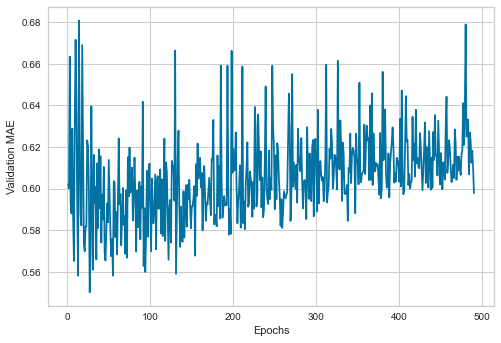

In [68]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

Le nombre d'epochs optimal semble se situer vers 120-130. On va donc choisir la valeur de 120 pour entraîner notre modèle.

In [69]:
model = build_model()
model.fit(X_train, y_train, 
          epochs=120, batch_size=16, verbose=0)

### Evaluation du modèle

In [70]:
y_pred = model.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  0.71717
MSE:  0.79245
RMSE:  0.8901974927610097
RMPSE:  0.064
MAPE:  0.05001
R²:  0.49957


Les mesures d'évaluation du réseau de neurones sont les mêmes que pour les modèles de régression présentés plus haut. Cela permet d'effectuer une comparaison avec les mêmes variables sur la même unité. 

Le coefficient de détermination est moins important que lors de l'utilisation de l'algorithme XGBoost (50% vs 76% pour l'algorithme XGBoost). Cependant, les autres variables sont meilleures qu'avec l'algorithme XGBoost. Les erreurs de prédiction sont de plus ou moins 0.06% (contre 0.11% pour l'algorithme XGBoost). 

## Prédiction des émissions de CO2 (sans ENERGY STAR Score)

In [71]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["PrimaryPropertyType"])

y_train = train_set[["SiteEnergyUse(kBtu)_log"]]
y_test = test_set[["SiteEnergyUse(kBtu)_log"]]
X_train = train_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "ENERGYSTARScore", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors", "Neighborhood", "Latitude", "Longitude"], axis=1)
X_test = test_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "ENERGYSTARScore", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors","Neighborhood", "Latitude", "Longitude"], axis=1)

In [72]:
# Séparation des variables catégorielles et numériques

cat_var = ["PrimaryPropertyType", "NbofFloors", "NbofBuildings", "HasParking", "Clusters", "Bins_Age"]
num_var = ["PropertyGFATotal", "degreeDaysH", "degreeDaysC"]

In [73]:
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [74]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [75]:
k = 5
num_val_samples = len(X_train)//k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
    [X_train[:i * num_val_samples],
     X_train[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [y_train[:i * num_val_samples],
     y_train[(i + 1) * num_val_samples:]],
    axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [76]:
print(all_scores)
print("MAE moyen:", np.mean(all_scores).round(2))

[0.5501109957695007, 0.5438231229782104, 0.5902246832847595, 0.5722099542617798, 0.7008348107337952]
MAE moyen: 0.59


In [77]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
    [X_train[:i * num_val_samples],
     X_train[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [y_train[:i * num_val_samples],
     y_train[(i + 1) * num_val_samples:]],
    axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [78]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

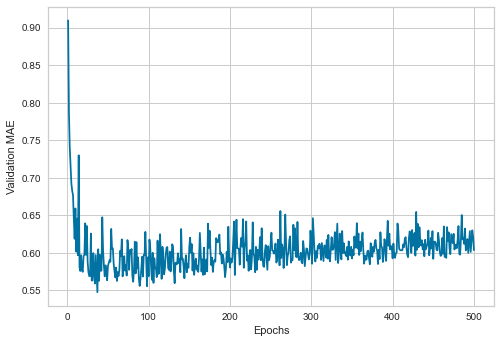

In [79]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

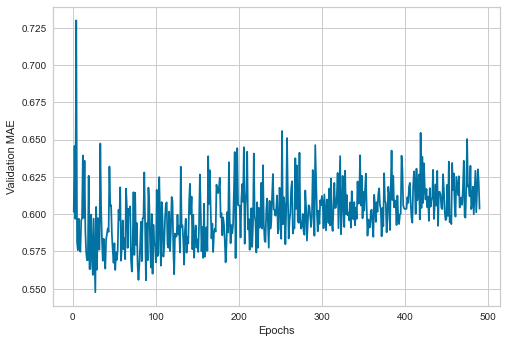

In [80]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [81]:
model = build_model()
model.fit(X_train, y_train, 
          epochs=120, batch_size=16, verbose=0)

In [82]:
y_pred = model.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  0.54192
MSE:  0.52039
RMSE:  0.7213823627894275
RMPSE:  0.051
MAPE:  0.03734
R²:  0.67137


Le coefficient de détermination de ce réseau de neurones est meilleur que celui obtenu avec l'algorithme de XGBoost (67% vs 64%). De plus, les scores évaluant le pourcentage d'erreur de prédiction sont meilleures (0.03% vs 0.31% pour le MAPE/ 0.05% vs 1.7% pour le RMSE). 

## Prédiction des émissions de CO2 (avec ENERGY STAR Score)

In [83]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["PrimaryPropertyType"])

y_train = train_set[["TotalGHGEmissions_log"]]
y_test = test_set[["TotalGHGEmissions_log"]]
X_train = train_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors", "Neighborhood", "Latitude", "Longitude"], axis=1)
X_test = test_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors","Neighborhood", "Latitude", "Longitude"], axis=1)

In [84]:
# Séparation des variables catégorielles et numériques

cat_var = ["PrimaryPropertyType", "NbofFloors", "NbofBuildings", "HasParking", "Clusters", "Bins_Age"]
num_var = ["PropertyGFATotal", "degreeDaysH", "degreeDaysC", "ENERGYSTARScore"]

In [85]:
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [86]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [87]:
k = 5
num_val_samples = len(X_train)//k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
    [X_train[:i * num_val_samples],
     X_train[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [y_train[:i * num_val_samples],
     y_train[(i + 1) * num_val_samples:]],
    axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [88]:
print(all_scores)
print("MAE moyen:", np.mean(all_scores).round(2))

[0.7774556279182434, 0.8385491371154785, 0.8389540314674377, 0.8666681051254272, 0.8183314204216003]
MAE moyen: 0.83


In [89]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
    [X_train[:i * num_val_samples],
     X_train[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [y_train[:i * num_val_samples],
     y_train[(i + 1) * num_val_samples:]],
    axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [90]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

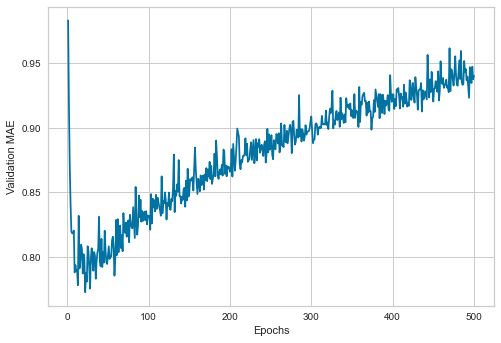

In [91]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

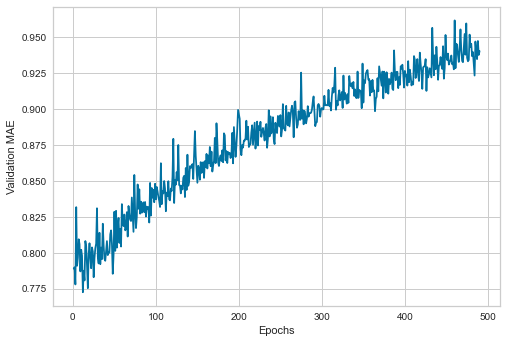

In [92]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [95]:
model = build_model()
model.fit(X_train, y_train, 
          epochs=300, batch_size=16, verbose=0)

In [96]:
y_pred = model.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  0.84663
MSE:  1.23617
RMSE:  1.1118324890463285
RMPSE:  1.348
MAPE:  0.41582
R²:  0.45205
